In [1]:
import numpy as np, os, sys
sys.path.append("..")
import wandb

import torch
from torch import nn
from torch.nn import functional as F 

from src.utils.synthetic_seqdata import download_data, load_data, sequence_string_to_one_hot
from src.models import DeepBindCNN
from src.trainer import Trainer
from src.utils.datasets import DNASequenceDataset
from sklearn.metrics import roc_auc_score, roc_curve
from src.utils import metrics

import matplotlib as mpl 
from matplotlib import pyplot as plt 
%matplotlib inline

In [2]:
# get data 
savedir = "./data"
# _=download_data(savedir)
Xs, Ys = load_data(savedir=savedir)
len(Xs['train']), Ys, len(Ys['train']), len(Ys['valid']), len(Ys['test'])

(14000,
 {'train': array([1., 1., 0., ..., 1., 0., 1.], dtype=float32),
  'valid': array([0., 1., 1., ..., 0., 0., 1.], dtype=float32),
  'test': array([0., 1., 0., ..., 1., 1., 1.], dtype=float32)},
 14000,
 2000,
 4000)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:
config = {
    "batch_size": 32,
    "learning_rate": 0.001,
    "architecture": "deepbind",
    "dataset": "synthetic data",
    "epochs": 35,
    "patience": 3,
    }

In [5]:
WANDB= False
if WANDB:

    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project="deepbind_synthetic_aug3",

        # track hyperparameters and run metadata
        config=config
    )

In [6]:
# set up datasets
datasets = {}
for k in Xs:
    datasets[k] = DNASequenceDataset(sequences=Xs[k], labels=Ys[k], alphabet="ACGT")

# set up dataloaders 
loaders = {}
for k, dataset in datasets.items():
    if k == 'train':
        loaders[k] = torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'], shuffle=True)
    else:
        loaders[k] = torch.utils.data.DataLoader(dataset, batch_size=config['batch_size'])


In [7]:
# set up the model, lossfn, optimizer, trainer 
model = DeepBindCNN(input_size=4, output_size=1, kernel_size=9)
lossfn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
metrics_list = [getattr(metrics, met) for met in ['accuracy', 'auroc']]
trainer = Trainer(model, lossfn, optimizer, metrics=metrics_list, wandb=False)

history = trainer.fit(
            loaders['train'], 
            val_loader=loaders['valid'], 
            nepochs=config['epochs'], 
            patience=config['epochs'],
            save_path='best_model.pt'
                    )

Model saved at epoch 1, val_loss: inf -> 0.6942
Epoch:   1/35, loss: 0.7218, accuracy: 0.4940, auroc: 0.7497, val_loss: 0.6942, val_accuracy: 0.4896, val_auroc: 0.7860
Model saved at epoch 2, val_loss: 0.6942 -> 0.6712
Epoch:   2/35, loss: 0.6932, accuracy: 0.5003, auroc: 0.6759, val_loss: 0.6712, val_accuracy: 0.4948, val_auroc: 0.6697
Model saved at epoch 3, val_loss: 0.6712 -> 0.6329
Epoch:   3/35, loss: 0.6542, accuracy: 0.5047, auroc: 0.6666, val_loss: 0.6329, val_accuracy: 0.5026, val_auroc: 0.7078
Model saved at epoch 4, val_loss: 0.6329 -> 0.6063
Epoch:   4/35, loss: 0.6450, accuracy: 0.5051, auroc: 0.6942, val_loss: 0.6063, val_accuracy: 0.5051, val_auroc: 0.7297
Model saved at epoch 5, val_loss: 0.6063 -> 0.5952
Epoch:   5/35, loss: 0.6240, accuracy: 0.5048, auroc: 0.7223, val_loss: 0.5952, val_accuracy: 0.5097, val_auroc: 0.7589
Model saved at epoch 6, val_loss: 0.5952 -> 0.5934
Epoch:   6/35, loss: 0.6101, accuracy: 0.5049, auroc: 0.7448, val_loss: 0.5934, val_accuracy: 0.5

In [8]:
model.load_state_dict(torch.load("best_model.pt"));

In [9]:
model = model.to("cpu")
ytest, ytestpred = [], []
for batch in loaders['test']:
    xtest, _ytest = batch
    _ytestpred = torch.sigmoid(model(xtest)).argmax(1).detach().numpy()
    ytestpred.append(_ytestpred)
    ytest.append(_ytest)
ytest = np.hstack(ytest)
ytestpred = np.hstack(ytestpred)
print((ytest == ytestpred).sum() / len(ytest))

0.49625


In [8]:
# # set up the model, lossfn, optimizer, trainer 
# model = DeepBindCNN(input_size=4, output_size=1, kernel_size=3)
# lossfn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
# metrics_list = [getattr(metrics, met) for met in ['accuracy', 'auroc']]
# trainer = Trainer(model, lossfn, optimizer, metrics=metrics_list, wandb=False)

# # fit model
# history = trainer.fit(loaders['train'], val_loader=loaders['valid'], nepochs=config['epochs'], save_path='best_model.pt')

Model saved at epoch 1, val_loss: inf -> 52.0466
Epoch:   1/35, loss: 54.4324, accuracy: 0.5025, auroc: 0.7510, val_loss: 52.0466, val_accuracy: 0.4896, val_auroc: 0.7691
Epoch:   2/35, loss: 53.7717, accuracy: 0.5003, auroc: 0.7762, val_loss: 52.1244, val_accuracy: 0.4958, val_auroc: 0.7810
Model saved at epoch 3, val_loss: 52.0466 -> 51.7995
Epoch:   3/35, loss: 53.7043, accuracy: 0.5024, auroc: 0.7841, val_loss: 51.7995, val_accuracy: 0.5104, val_auroc: 0.7888
Epoch:   4/35, loss: 53.5970, accuracy: 0.4997, auroc: 0.7910, val_loss: 52.0874, val_accuracy: 0.5104, val_auroc: 0.7755
Model saved at epoch 5, val_loss: 51.7995 -> 51.6671
Epoch:   5/35, loss: 53.4645, accuracy: 0.4996, auroc: 0.7957, val_loss: 51.6671, val_accuracy: 0.5104, val_auroc: 0.8018
Epoch:   6/35, loss: 53.3963, accuracy: 0.4977, auroc: 0.7996, val_loss: 51.7664, val_accuracy: 0.4901, val_auroc: 0.7907
Epoch:   7/35, loss: 53.4015, accuracy: 0.5027, auroc: 0.8018, val_loss: 51.7493, val_accuracy: 0.5104, val_auroc

In [11]:
history.keys()

dict_keys(['loss', 'accuracy', 'auroc', 'val_loss', 'val_accuracy', 'val_auroc'])

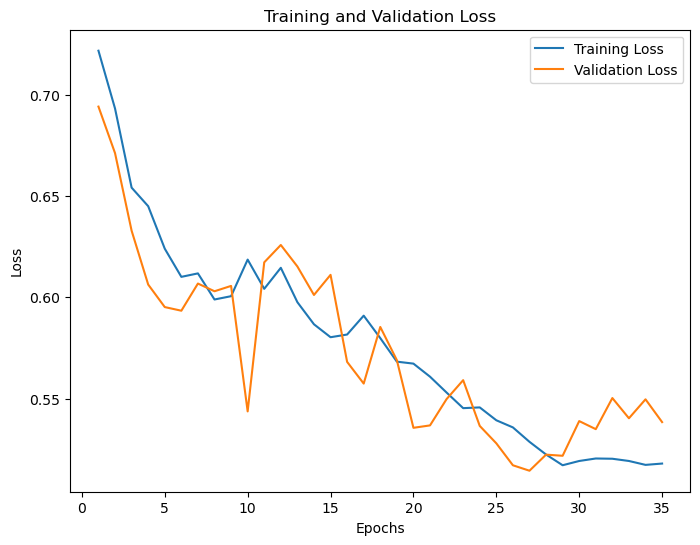

In [15]:
# Plot training/validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(history['loss'])+1), history['loss'], label='Training Loss')
plt.plot(range(1, len(history['val_loss'])+1), history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Test AUROC: 0.8354


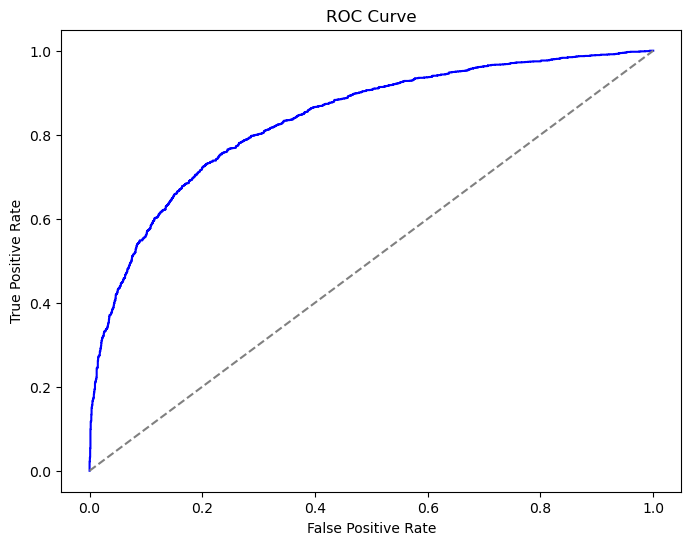

In [13]:
# Calculate AUROC for test predictions
model.eval()
test_scores = []
test_labels = []
with torch.no_grad():
    for inputs, labels in loaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_scores.extend(outputs.cpu().squeeze().tolist())
        test_labels.extend(labels.cpu().tolist())

test_auroc = roc_auc_score(test_labels, test_scores)
print(f"Test AUROC: {test_auroc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [14]:
wandb.finish()